**Keywords**: Adversarial Robustness, FGSM/PGD Attack, Certification

**About the dataset**: \
The [MNIST](https://en.wikipedia.org/wiki/MNIST_database) database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems.\
The MNIST database contains 70,000 labeled images. Each datapoint is a $28\times 28$ pixels grayscale image.\
Here we will be starting off with a pre-trained 2-hidden-layer model on the full MNIST dataset.

**Agenda**:
* Implement adversarial attack on an MNIST neural network model as well as visualize those attacks. 
* Solve this by using the inner maximization problem using FGSM (Fast Gradient Sign Method) and PGD (Projected Gradient Descent).
* Perform verification of the model using Interval-Bound -Propagation (IBP).

---

### Preprocessing

In [ ]:
# install this library
!pip install gdown

In [2]:
# imports 
import torch
import torch.nn as nn
import numpy as np
import requests
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gdown
from zipfile import ZipFile

In [3]:
# setting hardware device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# loading the dataset full MNIST dataset
mnist_train = datasets.MNIST("./data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

mnist_train.data = mnist_train.data.to(device)
mnist_test.data = mnist_test.data.to(device)

mnist_train.targets = mnist_train.targets.to(device)
mnist_test.targets = mnist_test.targets.to(device)

In [5]:
# number of target classes
num_classes = 10
num_classes_test = 2 

In [6]:
# reshaping and min-max scaling
X_train =  (mnist_train.data.reshape((mnist_train.data.shape[0], -1))/255).to(device)
y_train = mnist_train.targets
X_test = (mnist_test.data.reshape((mnist_test.data.shape[0], -1))/255).to(device)
y_test = mnist_test.targets

* We will be using a pre-trained 2-hidden layer neural network model (`nn_model`) that takes as input features vectors of size 784, and ouputs logits vector of size 10. Each of the two hidden layers are of size 1024.

* This is a highly accurate model with train accuracy of approx 99.88% and test accuracy of approx 98.14%.

* We will also be loading and initializing a dummy model (`test_model`) for unit testing code implementation.

In [ ]:
# loading pretrained and dummy model
url_nn_model = 'https://bit.ly/3sKvyOs'
url_models   = 'https://bit.ly/3lsVcDn'
gdown.download(url_nn_model, 'nn_model.pt')
gdown.download(url_models, 'models.zip')
ZipFile("models.zip").extractall("./")

In [9]:
from model import NN_Model
from test_model import Test_Model
nn_model = torch.load("./nn_model.pt").to(device)
print('Pretrained model (nn_model):', nn_model)

Pretrained model (nn_model): NN_Model(
  (l1): Linear(in_features=784, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=1024, bias=True)
  (l3): Linear(in_features=1024, out_features=10, bias=True)
)


In [10]:
test_model = Test_Model().to(device)
print('Dummy model (test_model):', test_model)

Dummy model (test_model): Test_Model(
  (l1): Linear(in_features=2, out_features=3, bias=True)
  (l2): Linear(in_features=3, out_features=3, bias=True)
  (l3): Linear(in_features=3, out_features=2, bias=True)
)


In [11]:
# creating a list of ordered layers for each of the neural network models for easy access.
model_layers = [layer for layer in nn_model.children()] # for nn_model
test_model_layers = [layer for layer in test_model.children()] # for dummy model

In [12]:
model_layers

[Linear(in_features=784, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=1024, bias=True),
 Linear(in_features=1024, out_features=10, bias=True)]

In [13]:
# utility function to plot the images
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
            ax[i][j].set_axis_off()
        plt.tight_layout()

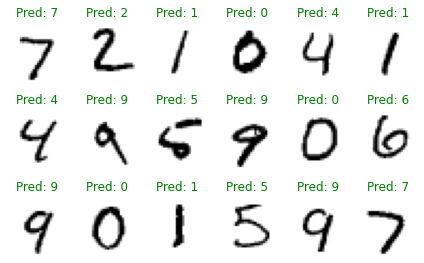

In [14]:
# let us visualize a few test examples
example_data = mnist_test.data[:18]/255
example_data_flattened  = example_data.view((example_data.shape[0], -1)).to(device) # needed for training
example_labels = mnist_test.targets[:18].to(device)
plot_images(example_data, example_labels, nn_model(example_data_flattened), 3, 6)



---




### Fast Gradient Sign Method (FGSM) attack:  
Create a few adversarial examples using FGSM attack. Using an attack budget $\epsilon=0.05$.

In the Fast Gradient Sign Method (FGSM), the perturbation $\delta$ on an input example (e.g. input image) $X$ is given by $\epsilon\cdot sign(g)$, where $g$ is the gradient of the loss function $g:=∇_\delta \ell(h_θ (x+δ),y)$, and $ℓ$ is the loss function, more precisely `nn.CrossEntropyLoss`. In the first timestep, this value of $\delta$ is $0$.

### Function `fgsm` which takes as input the neural network model (`model`), test examples (`X`), target labels (`y`), and the attack budget (`epsilon`). Returns the value of the perturbation ($\delta$) after one gradient descent step.

In [15]:
def fgsm(model,X,y,e):

    model = model.to(device)
  
    criterion = torch.nn.CrossEntropyLoss()
  
    delta = torch.zeros_like(X, requires_grad=True)
  
    output=model(X + delta)
  
    loss=criterion(output, y)
  
    loss.backward()
  
    sign_g = delta.grad.detach().sign()
  
    p =  e * sign_g
    
    return p

### Considering the first few examples from the training dataset which are already defined above as `example_data_flattened` and `example_labels`. Using the function `fgsm`, getting the value of `delta` for these examples. Performing prediction on the modified dataset (`example_data_flattened + delta`), and constructing a similar plot of images as above. Lets see if the attack is successful.

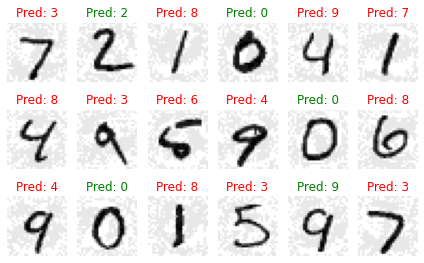

In [16]:
delta = fgsm(nn_model,example_data_flattened,example_labels,0.05)
mod_images = example_data_flattened+delta
predict_labels = nn_model(mod_images)
plot_images(mod_images.reshape(example_data.shape), example_labels, predict_labels, 3, 6)



---



### Projected Gradient Descent (PGD) attack: 
Creating a few adversarial examples using PGD attack. Use an attack budget $\epsilon=0.05$.  (10 points)

For the Projected Gradient Descent (PGD) attack, you create an adversarial example by iteratively performing gradient descent with a fixed step size $\alpha$. The update rule is: $δ:=P(δ+α∇_δ ℓ(h_θ(x+δ),y))$, where $δ$ is the perturbation, $θ$ are the frozen DNN parameters, $x$ and $y$ is the training example and its ground truth label respectively, $h_θ$ is the hypothesis function, $ℓ$ denotes the loss function, and $P$ denotes the projection onto a norm ball ($l_\infty, l_1, l_2$, etc.) of interest. For $l_\infty$ ball, this just means clamping the value of $\delta$ between $-\epsilon$ and $\epsilon$.

### Function `pgd` that takes as input the neural network model (`model`), training examples (`X`), target labels (`y`), step size (`alpha`), attack budget (`epsilon`), and number of iterations (`num_iter`). Returns the perturbation ($\delta$) after `num_iter` gradient descent steps. 

In [19]:
def pgd(model,X,y,a,e,num_iter):
    model = model.to(device)
  
    criterion = torch.nn.CrossEntropyLoss()
  
    delta = torch.zeros_like(X, requires_grad=True)
  
    for iter in range(num_iter):
  
      output=model(X+delta)
  
      loss=criterion(output, y)
  
      loss.backward()
  
      grad = a * delta.grad.detach()
  
      new_delta = delta + grad
  
      delta.data = new_delta.clamp(-e,e)
  
      delta.grad.zero_()
  
    return delta.detach()

### **#2.** Now using the PGD attack for the examples from `example_data_flattened`. Using `alpha=1000`, `num_iter=1000`, and creating a similar plot as before. 

### The value of `alpha` is large because the neural network model is pretrained and is therefore at the local minima. The value of gradients here is extremely small, and we therefore need a huge value of step size to have any hope of moving out of the local minima.

### Lets see if the attack is successful.

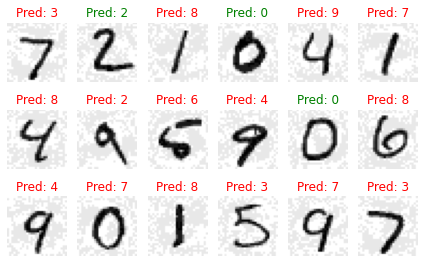

In [20]:
delta = pgd(nn_model,example_data_flattened,example_labels,1000,0.05,1000)
mod_images = example_data_flattened+delta
predict_labels = nn_model(mod_images)
plot_images(mod_images.reshape(example_data.shape), example_labels, predict_labels, 3, 6)



---



### Using FGSM and PGD to create adversarial examples using the complete test dataset. Creating the datasets with different values of `epsilon: [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]`. For each of the dataset created with different `epsilon` values and attack type, getting the model accuracies. Plotting a graph of accuracy vs. epsilon for both attack types. Note that `epsilon=0` means no attack.

In [21]:
def accuracy(predict,actual):
  
   l = torch.where(predict==actual,1,0)
 
   accuracy = l.sum()/len(predict)
 
   return round(accuracy.item(),2)

In [22]:
def attack_accuracy(model, attack, X,y):

    epsilon_accuracy = []
    epsilon = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
  
    for i in epsilon:
        if i == 0:
            y_predict = model(X).to(device)
        else:
            if attack == 'fgsm':
                delta = fgsm(model,X,y,i)
            if attack == "pgd":
                delta = pgd(model,X,y,1000,i,1000)
            y_predict = model( X + delta ).to(device)
        
        y_predict = torch.argmax(y_predict, dim=1)
        accuracy_ = accuracy(y_predict,y)
        epsilon_accuracy.append((i,accuracy_))
  
    plt.plot(*zip(*epsilon_accuracy))
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epsilon')
    plt.show()

In [23]:
test_data = mnist_test.data/255
test_data_flattened  = test_data.view((test_data.shape[0], -1)).to(device) # needed for training
test_labels = mnist_test.targets.to(device)

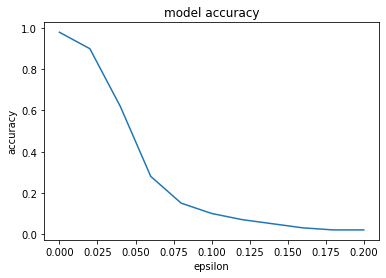

In [24]:
attack_accuracy(nn_model, "fgsm", test_data_flattened,test_labels)

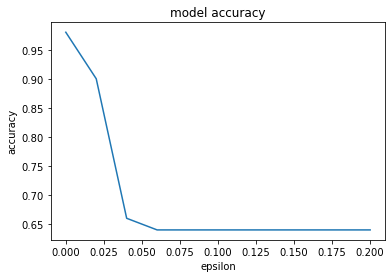

In [25]:
attack_accuracy(nn_model, "pgd", test_data_flattened,test_labels)



---



### Using the Interval-Bound-Propagation (IBP) technique to certify robustness of the model through lower bound with a given value of epsilon.

* In this section, we will find the lower and upper bounds for each neuron of each of the linear layers of the neural network model.

* Note that the initial bound is the bound of the first layer, which is the input example. For the $l_\infty$ perturbation, the initial lower bound is simply $max(0, x-\epsilon)$, and the  initial upper bound is $min(1, x+\epsilon)$, for an input example $x$ (Note that each value of $x$ must lie in between 0 and 1, thats why the $min$ and $max$).

* In the function, propagate the initial bound across all layers of the neural network and return a list of tuples of *pre-activation* lower and upper bound for each layer. The *pre-activation* bounds are the bound before applying ReLU activation. 

* Let's review a bit of the IBP bounds: let $z=Wx+b$ denote an intermediate linear layer of the model, and suppose $\hat{l} \le x \le \hat{u}, l \le z \le u$, we have:\
$l=W_+\hat{l}+W_-\hat{u}+b$\
$u=W_+\hat{u}+W_-\hat{l}+b$\
Note $l, u$ here are the *pre-activation* bounds

* If a non-linear ReLU activation function $\sigma(\cdot)$ is applied to the layer $z=Wx+b$, then the bounds of $\sigma(z)$ will be: $l=\sigma(\hat{l}), u = \sigma(\hat{u})$ as $\sigma$ is a monotonically non-decreasing function. I.e. $l \leq \sigma(z) \leq u$. The $l,u$ here are the *post-activation* bounds. Note, here we use $\hat{l}$ and $\hat{u}$ to denote the bounds of the previous layer: $\hat{l} \leq z \leq \hat{u}$. 

### Function `bound_propagation` which takes as input an ordered list of layers of the model (`model_layers`), a feature vector (`x`), and attack budget (`epsilon`). Returns a list of tuples of `pre-activation` lower and upper bound tensors for each layer.

In [26]:
def bound_propagation(model_layers,x,e):

    pre_activation_bounds = []
  
    initial_lower_bound = (x - e).clamp(min=0)
    initial_upper_bound = (x + e).clamp(max=1)
  
    pre_activation_bounds.append((initial_lower_bound, initial_upper_bound))
  
    for layer in model_layers:
  
        lower_bound = (layer.weight.clamp(min=0) @ initial_lower_bound.t() + layer.weight.clamp(max=0) @ initial_upper_bound.t() 
                    + layer.bias[:,None]).t()
        upper_bound = (layer.weight.clamp(min=0) @ initial_upper_bound.t() + layer.weight.clamp(max=0) @ initial_lower_bound.t() 
                    + layer.bias[:,None]).t()
        pre_activation_bounds.append((lower_bound, upper_bound))
    
        lower_bound = lower_bound.clamp(min=0)
        upper_bound = upper_bound.clamp(min=0)
    
        initial_lower_bound,initial_upper_bound = lower_bound, upper_bound
  
    return pre_activation_bounds

### Let the lower and upper bounds of the final layer of the model be $l^{final}$ and $u^{final}$ respectively. Then we say that an input example $x$ has a robutness certificate $\epsilon$ if the criteria: $l^{final}[c]-u^{final}[i]>0, \forall i\ne c$, where $c$ denotes the ground truth class of the input $x$. 

* We need to determine the maximum value of epsilon for certified robustness against an adversarial attack for a given example. We can do the same using binary search over a few values of epsilon.

* Function `binary_search` that takes as input a sorted array of epsilon values (`epsilons`), an ordered list of neural network model layers (`model_layers`), examples (`X`), corresponding targets (`y`), the number of target classes (`num_classes`). It should return `certified_epsilons` which is a python list of the final values of epsilon certification for each example in input. You can use `None` when unable to find an epsilon value from epsilons. 

In [27]:
from torchvision.datasets.utils import T

def epsilon_check(model_layers,x,y,num_classes,c,e):

    preactivation_bounds = bound_propagation(model_layers,x,e)
  
    final_l = preactivation_bounds[-1][0][c]
    final_u = preactivation_bounds[-1][1][c]
  
    for i in range(num_classes):
        if y[c]!=i and final_l[y[c]] - final_u[i] > 0: return True
    return False

def binary_search(epsilons,model_layers,x,y,num_classes):
    certified_epsilons = []
  
    for c in range(x.shape[0]):
        p_front,p_back = 0,len(epsilons)-1
        found = False
    
        while p_front <= p_back:
            p_mid = int((p_front+p_back)/2)
      
            current = epsilon_check(model_layers,x,y,num_classes,c,epsilons[p_mid])
            current_1 = epsilon_check(model_layers,x,y,num_classes,c,epsilons[p_mid+1])
      
            if current and not current_1:
                found = True
                break
            elif current and current_1:
                p_front = p_mid+1
            else:
                p_back = p_mid-1
    
        if found: certified_epsilons.append(epsilons[p_mid])
        else: certified_epsilons.append(None)
  
  
    return certified_epsilons

### Report the certified values of epsilon on the first few examples.

In [28]:
# finding epsilon for first few examples of MNIST dataset using IBP
epsilons = [x/10000 for x in range(1, 10000)]
X = example_data_flattened[0:2]
y = example_labels[0:2]
binary_search(epsilons, model_layers, X, y, num_classes)

[0.0035, 0.0032]

---